# Set Random Number Seed (for Reproducibility)

In [1]:
import random
random.seed(101)

# Input Data (Edit for Your Particular Dataset)

In [2]:
import numpy as np
import random

# Data with 7 predictor variables and 1 response variable
data    = np.loadtxt(open('./statistics_large.csv','rb'),delimiter=',',skiprows=1)
numTest = 700

# Pick test data (rows of data matrix)
idx = random.sample(range(len(data)),numTest)

# Set aside test data (and remove the last column, which has the response variable)
predTest = data[idx,:]
predTest = np.delete(predTest,-1,1)

# Define training variables (both predictor and response)
varTrain = np.delete(data,idx,0)

# Here, we define two categories: low-valued response (< 25th percentile) and
# high-valued response (> 75th percentile). Rows with middling responses are
# removed, and response values are replaced with 0 (low value) or 1 (high value).
q1         = np.percentile(varTrain[:,-1],25)
q3         = np.percentile(varTrain[:,-1],75)
removeRows = []
for row in range(varTrain.shape[0]):
    if   ( varTrain[row, -1] >= q3 ) : varTrain[row, -1] = 1
    elif ( varTrain[row, -1] <= q1 ) : varTrain[row, -1] = 0
    else: removeRows.append(row)
varTrain = np.delete(varTrain,removeRows,0)

# Here we split the training data into predictors (all but last column) and
# response (last column)
predTrain = varTrain[..., :-1]
respTrain = varTrain[..., -1]

# What is required from this code block: training predictor matrix and 
# response vector, and test predictor matrix.

# Run LTST

***

## API

### import ltst

__ltst.ltst__ (_predTrain_, _respTrain_, _numTree_=1000, _sampSize_=0, _randomState_=101)

Instantiates an LTST class object.

Inputs:

1. _predTrain_: an mTrain x n 2D numpy predictor variable array with observations in rows and features in columns
2. _respTrain_: a response variable vector of length mTrain
3. _numTree_: the number of separate decision trees to create
4. _sampSize_: the number of rows to select from predTrain, without replacement, when constructing each tree. If zero, a default of np.power(mTrain,0.7) is assumed, to be consistent with the original R code on which the ltst module is based.
5. _randomState_: fixes the random_state parameter for DecisionTreeRegressor (for reproducibility)

Outputs:

1. An instance of class LTST.

***

__ltst.predict__ (_predTest_)

Generates a prediction for the local proportion of class 1 objects for each test set object.

Input:

1. _predTest_: an mTest x n 2D numpy predictor variable array with observations in rows and features in columns

Output:

1. An mTest x 2 2D numpy array; column 0 contains the estimated local proportion of class 1 objects, and column 1 contains the estimated variance for that proportion.

***

__ltst.test__ (_predictedProportion_, _globalProportion_=0.5)

Determines whether each test set datum lies in a region with a significantly high proportion of class 0 objects (0) or  a significantly high proportion of class 1 objects (1), or lies in a region whose proportion of class 1 objects is consistent with the null hypothesis given by _globalProportion_ (-1).

Inputs:

1. _predictedProportion_: the output from __ltst.predict__.
2. _globalProportion_: the global proportion of class 1 objects. Currently should not be changed from 0.5, and the response variable should be set up such that the global proportion is 0.5. This condition will be relaxed in the near future.

Output:

1. A vector of length mTest with values -1, 0, or 1 (see description of the function, above).

***

In [3]:
import ltst

trees = ltst.ltst(predTrain,respTrain)
pred  = trees.predict(predTest)
test  = trees.test(pred)

# Example of Visualization via Diffusion Map

Plots the first two diffusion map coordinates for the test-set data. 

1. Red: object lies in region with significantly low proportion of class 1 objects.
2. Blue: object lies in region with significantly high proportion of class 1 objects.
3. Green: object lies in region with proportion of class 1 objects consistent with the null.

To "tune" the map: adjust _perc_ (and optionally, _neigen_, though the map is more sensitive to _perc_). Here, the appearance of the map is to some extent secondary to the separation you can achieve between objects in "class 0 regions" and "class 1 regions".

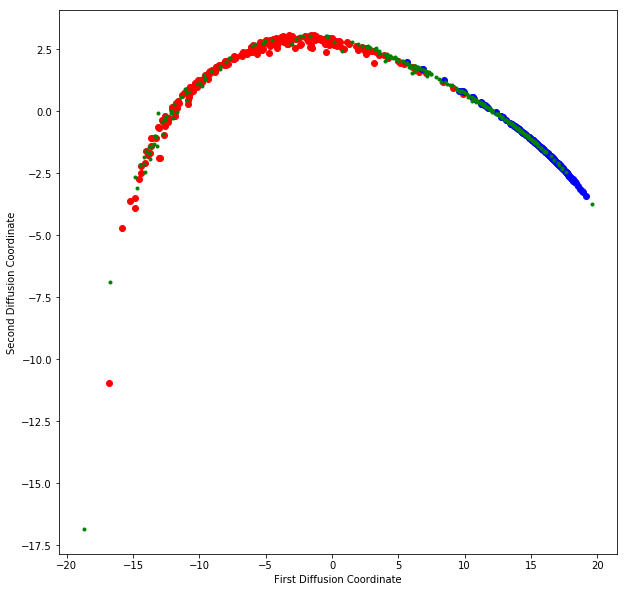

In [22]:
import matplotlib.pyplot as plt
from diffusionMap import diffuse
from scipy.spatial.distance import pdist,squareform

neigen  = 10
perc    = 30
p       = pdist(predTest)
D       = squareform(p)
eps     = np.square(np.percentile(p,perc))
diffMap = diffuse(D,neigen,eps)

plt.figure(figsize=(10,10))
s = np.where(test==0)[0]
plt.plot(diffMap.X[s,0],diffMap.X[s,1],'ro')
s = np.where(test==1)[0]
plt.plot(diffMap.X[s,0],diffMap.X[s,1],'bo')
s = np.where(test==-1)[0]
plt.plot(diffMap.X[s,0],diffMap.X[s,1],'g.')
plt.xlabel('First Diffusion Coordinate')
plt.ylabel('Second Diffusion Coordinate')
plt.show()

# Example of Visualization via Boxplots

Boxplots a given (filtered) statistic. The examples indicate that there is a marked difference in the distributions of the statistics in class-0-dominated regions vs. class-1-dominated regions.

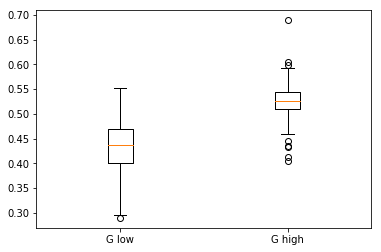

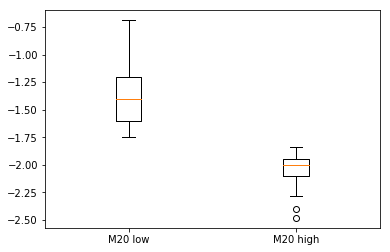

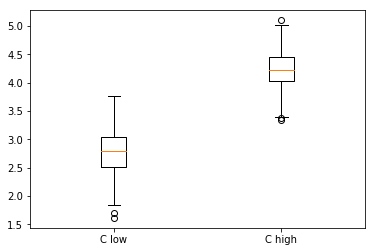

In [26]:
import matplotlib.pyplot as plt

sHi = np.where(test==1)[0]
sLo = np.where(test==0)[0]

plt.boxplot([predTest[sLo,3],predTest[sHi,3]],labels=['G low','G high'])
plt.show()
plt.boxplot([predTest[sLo,4],predTest[sHi,4]],labels=['M20 low','M20 high'])
plt.show()
plt.boxplot([predTest[sLo,5],predTest[sHi,5]],labels=['C low','C high'])
plt.show()